In [0]:
root_dir = '/content/drive/My Drive/CoLab/딥러닝 공부/pytorch/적대적 신경망/'

# 딥러닝을 해킹하는 적대적 공격

[논문] FGSM(Fast Gradient Sign Method) 설명 : Explaining and harnessing adversarial examples

[논문 링크](https://arxiv.org/pdf/1412.6572.pdf)

 사람이 착시를 겪듯 모델도 일종의 '착시'를 겪음. 다만 이미지를 인식하는 구조가 다르기 떄문에 컴퓨터가 겪는 착시는 사람과 다름. 머신러닝 모델의 착시를 유도하는 입력을 적데적 예제(adversarial exmaple)라고 함

![사람의 착시](https://t1.daumcdn.net/liveboard/scientist/0f82c81e2914440e9c4097f6f8e3f9a3.jpg)

![대체 텍스트](https://miro.medium.com/max/806/0*k3QpRlbCJoiuUkNa)

[출처](https://arxiv.org/abs/1412.6572) : Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." arXiv preprint arXiv:1412.6572 (2014).

위와 같이 판다를 판다라고 잘 인식하는 network에 어떠한 noise를 섞어 높은 확률로 다른 class로 인식하게 하는것을 Adversarial Attack이라 한다. 그리고 이때, 노이즈가 포함된 이미지 즉, 가장 오른쪽 사진들을 ***Adversarial Examples***라 한다. 단, 노이즈가 포함된 사진도 사람이 보기에는 원래의 사진과 구분되지 않아야한다.



### 1.적대적 공격이란?

머신러닝에 의존한 서비스가 많아지면서 자연스럽게 머신러닝의 보안도 중요해지고있으며 최근 구글 브레인에서 진행한 연구에 의하면 모든 머신러닝 분류기가 속임수에 의해 잘못된 예측을 할 수 있다고 함. 이러한 약점은 영상뿐만 아니라 텍스트와 오디오에도 적용될 수 있다고 최근 밝혀지고 있으며 공격방법이 조금만 더 발전되면 카페에 흐르는 음악에 몰래 명령을 넣어 음성비서가 오작동하게 할수도 있음.


잘 학습된 딥러닝 모델도 가끔 실수를 일으키기 마련이고 입력 데이터가 신경망 모델을 타고 흐르면서 계속 변환이 일어나는데, 각각의 변환은 입력의 특정구조에 매우 예민하게 반응하며 이처럼 모델이 예민하게 반응하는 부분을 공략함으로써 모델을 헷갈리게 할 수 있음.

본 실습에선 적대적 공격을 통해 ResNet과 DenseNet 같은 복잡한 모델을 무력화하기가 얼마나 쉬운지 실습해볼 예정

### 2.적대적 공격의 종류




![대체 텍스트](https://hackaday.com/wp-content/uploads/2018/04/fooled_featured.png?w=800)

[출처](https://ieeexplore.ieee.org/abstract/document/8601309) : Su, Jiawei, Danilo Vasconcellos Vargas, and Kouichi Sakurai. "One pixel attack for fooling deep neural networks." IEEE Transactions on Evolutionary Computation 23.5 (2019): 828-841.

적대적 공격은 적절한 노이즈를 생성해 사람의 눈에는 똑같이 보이지만, 머신러닝 모델을 헷갈리게 만드는 적대적 예제를 생성하는것이 핵심. 인식오류를 일으키지만 원본과 차이가 가장 적은 잡음을 찾는 것이고, 결국 최적화 문제로 해석가능. 적대적 공격에선 오차를 줄이기보단 극대화하는 쪽으로 잡음을 최적화하게됨

잡음을 생성하는 방법은 매우 많으며, 극단적으로 이미지에서 픽셀하나만 건드려 분류기의 예측을 완전히 빗나가게 할수 있음. 상기 사진의 예시에선 검정색 단어가 원래의 레이블이고 파란색단어는 픽셀 하나의 값을 바꿔 예측한 값

적대적 예제에서 잡음의 생성 방법은 분류 기준이 무엇이냐에 따라 여러가지로 나눠지며

첫째, 기울기와 같은 모델 정보가 필요한지에 따라, 모델 정보를 토대로 잡음을 생성하는 화이트박스(white box)방법과 모델 정보 없이 생성하는 블랙박스(Black box)로 나뉨

둘째,원하는 정답으로 유도할 수 있다면 표적(targeted), 아니라면 비표적(non-targeted)으로 분류

셋째, 잡음을 생성하기 위해 반복된 학습(최적화)이 필요하면 반복(iterative), 아니면 원샷(one-shot)으로 나눌수 있음


넷째, 한 잡음이 특정 입력에만 적용되는지, 혹은 모든 이미지에 적용될 수 있는 범용적인 잡음인지로 나눌수 있음

가장 강력한 공격방법은 모델 정보가 필요없고, 원하는 정답으로 유도할 수 있고, 복잡한 모델이 필요 없으며 여러 모델에서 동시에 적용할 수 있는 방법이겠지만, 각 특징에는 기회비용이 존재



### 3.FGSM 공격 (ResNet101 공격)

앞서 말했듯, 정상 데이터에 잡음을 더해 머신러닝 모델을 헷갈리게 하는 데이터가 바로 적대적 예제임. 이번 예제에서는 FGSM이란 방법으로 적대적 예제를 생성하여 미리 학습된 딥러닝 모델을 공격함

FGSM은 반복된 학습 없이 잡음을 생성하는 원샷 공격으로, 입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성하며 공격목표를 정할 수 없는 non-targeted 방식이자, 대상모델의 정보가 필요한 화이트박스 방식

맨처음 판다 그림처럼 잡음이 눈에 보이지 않아야하므로 아주작은 숫자를 곱해서 (그림에선 0.007) 희석한 후 원본 그림에 더하면 원본데이터를 57.7%의 신뢰도로 '판다'라고 예측하고 있었지만, 잡음이 섞이면서 99.3%의 신뢰도로 '긴팔원숭이'로 예측하는 것을 볼 수있음.





In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms

import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt

##### 3.1 학습된 모델 불러오기

In [0]:
model = models.resnet101(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
CLASSES = json.load(open(root_dir+'data/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]
idx2class[:10]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus']

##### 3.2 공격할 이미지 불러오기

In [0]:
img = Image.open(root_dir+'data/corgie.jpg')

In [0]:
img_transforms = transforms.Compose([
                                     transforms.Resize((224,224),Image.BICUBIC),
                                     transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print('이미지 텐서 모양:',img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


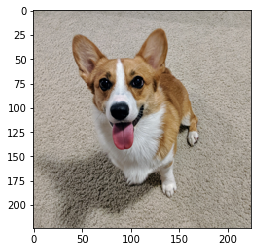

In [0]:
# 시각화를 위해 넘파이 행렬 변환
original_img_view = img_tensor.squeeze(0).detach()  # [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

# 텐서 시각화
plt.imshow(original_img_view)

##### 3.3 공격 전 성능 확인하기

In [0]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


##### 3.4 FGSM 공격 함수 정의

FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고, 그것을 왜곡하여 원본이미지에 더하는것. 기울기는 모델이 학습할 때 각 필셀이 미치는 영향이라 생각하면 됨

모델을 헷갈리게 하려면 모델의 오찻값을 극대화해야 하며 딥러닝 모델을 학습할 때는 기울기의 정반대편으로 가중치를 조절하며 오차를 줄여나갔음

In [0]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


##### 3.5 적대적 예제 생성

원본 이미지에 대한 기울기를 추출하기위해 requires_grad=True를 사용하여 이미지에 대한 기울기를 보존하도록 명시

평범하게 학습을 진행하듯 오찻값과 기울깃값을 구한 후, 역전파를 마치고 나면 img_tensor텐서의 grad.data 변수에 각 픽셀의 기울기가 저장됨. 이것을 추출하여 epsilon값과 함께 원본 이미지에 더하여 가짜 이미지 perturbed_data를 생성

In [0]:
### 참고
import torch

w = torch.tensor(1.0,requires_grad=True)
a = w*3
l = a**2

l.backward()

print('l을 w로 미분한 값은 {}'.format(w.grad))

l을 w로 미분한 값은 18.0


In [0]:
# 이미지의 기울기값을 구하도록 설정
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오차값 구하기 (레이블 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263])) 

# 기울기값 구하기
model.zero_grad()
loss.backward()

# 이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)

##### 3.6 적대적 예제 성능 확인

같은 모델이지만 방금 생성된 적대적 예제를 휘핏으로 예측하는것을 볼수 있음

In [0]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 172
레이블 이름: whippet


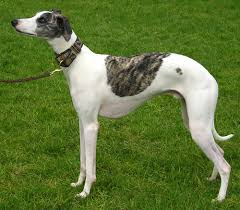

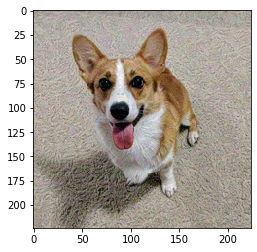

In [0]:
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

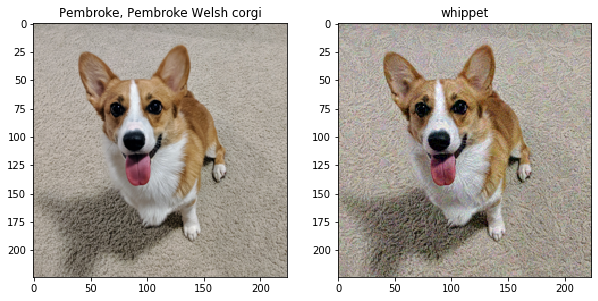

In [0]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()

### 4.epsilon에 따른 에러율 계산(MNIST with LeNet)



##### 4.1 입력

- epsilons : 실행에 사용할 엡실론의 리스트. 엡실론 0의 값은 원래 테스트 셋의 모델성능을 나타내므로 목록에 유지하는것이 중요. 또한 직관적으로 엡실론이 클수록 작은변화가 더 눈에 띄지만 모델정확도를 저하시키는 측면에서 더 효과가 있음. 여기서 데이터의 범위는 0~1이기 때문에 엡실론의 값은 1을 초과하면 안됨

- pretrained model : 파이토치 튜토리얼에 있는 모델 그냥 가져왔습니다


In [0]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = root_dir+"/data/lenet_mnist_model.pth"

##### 4.2 공격을 받는 모델

앞서 말한대로(pretrained model) 공격을 받는모델은 파이토치 튜토리얼에 있는 모델이므로 본인의 MNIST 모델을 학습 및 저장하는 방식으로 하거나 제공된 모델을 다운로드 해 사용하는 식으로 진행할 수 있음. 여기서 Net 정의 및 테스트 데이터 로더는 MNIST 예제에서 복사 하였으며 이 섹션의 목적은 모델과 데이터 로더를 정의한 다음, 모델을 초기화하고 미리 학습된 가중치를 읽어오는 것임.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir+'data/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [0]:
model = Net()
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

##### 4.3 테스팅 함수

테스트 기능을 호출할때 MNIST 테스트 셋에서 전체 테스트 단계를 수행하고 최종 정확도를 측정함

In [0]:
def test( model, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

##### 4.4 공격 실행

In [0]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


##### 4.5 결과
정확도 vs 엡실론

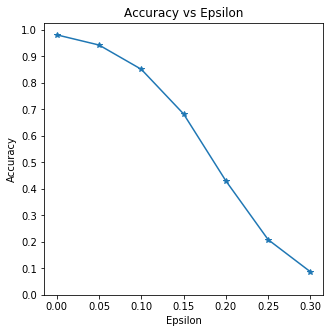

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

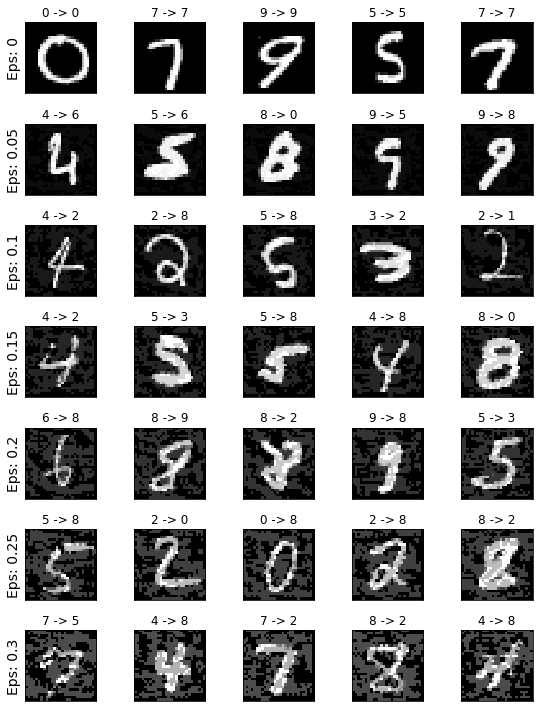

In [0]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# 결론 : 이런거 왜만들까...